In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd

from IPython.display import clear_output
from keras.models import Model
from keras.preprocessing import image
from keras.callbacks import Callback
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import backend as K
from google.colab import files
from keras.metrics import MeanIoU

In [2]:
! pip install -q kaggle

Downloading the dataset:

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"isidoraslavkovic","key":"20835bd9df1980dbdccb3523dbd1199d"}'}

In [4]:
# !rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                           Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          14815        431  1.0              
ruchi798/data-science-job-salaries                                 Data Science Job Salaries                             7KB  2022-06-15 08:59:12           3267        110  1.0              
zusmani/petrolgas-prices-worldwide                                 Petrol/Gas Prices Worldwide                          10KB  2022-06-24 01:25:33           1749         85  1.0              
imoore/age-dataset                           

In [5]:
!kaggle datasets download -d carlolepelaars/camvid

 99% 569M/575M [00:04<00:00, 139MB/s]
100% 575M/575M [00:04<00:00, 143MB/s]


In [6]:
!unzip camvid.zip

Archive:  camvid.zip
  inflating: CamVid/class_dict.csv   
  inflating: CamVid/test/0001TP_006690.png  
  inflating: CamVid/test/0001TP_006720.png  
  inflating: CamVid/test/0001TP_006750.png  
  inflating: CamVid/test/0001TP_006780.png  
  inflating: CamVid/test/0001TP_006810.png  
  inflating: CamVid/test/0001TP_006840.png  
  inflating: CamVid/test/0001TP_006870.png  
  inflating: CamVid/test/0001TP_006900.png  
  inflating: CamVid/test/0001TP_006930.png  
  inflating: CamVid/test/0001TP_006960.png  
  inflating: CamVid/test/0001TP_006990.png  
  inflating: CamVid/test/0001TP_007020.png  
  inflating: CamVid/test/0001TP_007050.png  
  inflating: CamVid/test/0001TP_007080.png  
  inflating: CamVid/test/0001TP_007110.png  
  inflating: CamVid/test/0001TP_007140.png  
  inflating: CamVid/test/0001TP_007170.png  
  inflating: CamVid/test/0001TP_007200.png  
  inflating: CamVid/test/0001TP_007230.png  
  inflating: CamVid/test/0001TP_007260.png  
  inflating: CamVid/test/0001TP_007290.pn

Preprocessing data:

In [7]:
DIR_PATH = 'CamVid/'

In [8]:
class_dict = pd.read_csv(os.path.join(DIR_PATH + 'class_dict.csv'), index_col=0)
class_dict.head()

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0


In [9]:
cls2rgb = {cl:list(class_dict.loc[cl, :]) for cl in class_dict.index}
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}
idx2rgb

{0: array([ 64, 128,  64]),
 1: array([192,   0, 128]),
 2: array([  0, 128, 192]),
 3: array([  0, 128,  64]),
 4: array([128,   0,   0]),
 5: array([ 64,   0, 128]),
 6: array([ 64,   0, 192]),
 7: array([192, 128,  64]),
 8: array([192, 192, 128]),
 9: array([ 64,  64, 128]),
 10: array([128,   0, 192]),
 11: array([192,   0,  64]),
 12: array([128, 128,  64]),
 13: array([192,   0, 192]),
 14: array([128,  64,  64]),
 15: array([ 64, 192, 128]),
 16: array([64, 64,  0]),
 17: array([128,  64, 128]),
 18: array([128, 128, 192]),
 19: array([  0,   0, 192]),
 20: array([192, 128, 128]),
 21: array([128, 128, 128]),
 22: array([ 64, 128, 192]),
 23: array([ 0,  0, 64]),
 24: array([ 0, 64, 64]),
 25: array([192,  64, 128]),
 26: array([128, 128,   0]),
 27: array([192, 128, 192]),
 28: array([64,  0, 64]),
 29: array([192, 192,   0]),
 30: array([0, 0, 0]),
 31: array([ 64, 192,   0])}

In [10]:
class CamVidDataset():
    def __init__(self, DIR_PATH):
        self.train_images = self.readData(os.path.join(DIR_PATH + 'train'))
        self.train_masks = self.readData(os.path.join(DIR_PATH + 'train_labels'))
        self.test_images = self.readData(os.path.join(DIR_PATH + 'test'))
        self.test_masks = self.readData(os.path.join(DIR_PATH + 'test_labels'))
        self.val_images = self.readData(os.path.join(DIR_PATH + 'val'))
        self.val_masks = self.readData(os.path.join(DIR_PATH + 'val_labels'))
        self.arr_col = []

        for r, g, b in zip(class_dict['r'], class_dict['g'], class_dict['b']):
            self.arr_col.append([r, g, b]) 

                                          
    def readData(self, DirPath):
        img_names = []
        for f in os.listdir(DirPath):
            img_names.append(os.path.join(DirPath,f))
        img_names.sort()
        
        res = []
        for i in img_names:
            res.append(image.load_img(i, target_size=(128, 128)))
        return np.array(res)

    def images_to_arrays(self, images):
        res = []
        for img in images:
            x = image.img_to_array(img)
            res.append(x)
        res = np.array(res)
        print(res.shape)
        return res

        
    def color2index(self, y):
        y_ind = np.zeros((y.shape[0], y.shape[1]))
        y_cat = np.zeros((y.shape[0], y.shape[1], len(self.arr_col)))
        i = 1
        for i_color in self.arr_col:
            ind_i = np.where(
                (y[..., 0] == i_color[0]) 
                & (y[..., 1] == i_color[1])
                & (y[..., 2] == i_color[2])
            )
            y_ind[ind_i[0], ind_i[1]] = i
            y_cat[ind_i[0], ind_i[1], i-1] = 1 
            i += 1
        return y_cat, y_ind#, i-1

    def masks_to_arrays(self, masks):
        res = []
        for mask in masks:
            cat, _ = self.color2index(image.img_to_array(mask))
            res.append(cat)
        res = np.array(res)
        print(res.shape)
        return res

    def split_images(self):
        return (self.images_to_arrays(self.train_images),
                self.images_to_arrays(self.test_images),
                self.images_to_arrays(self.val_images))
    
    def split_masks(self):
        return (self.masks_to_arrays(self.train_masks),
                self.masks_to_arrays(self.test_masks),
                self.masks_to_arrays(self.val_masks))

In [11]:
dataset = CamVidDataset(DIR_PATH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


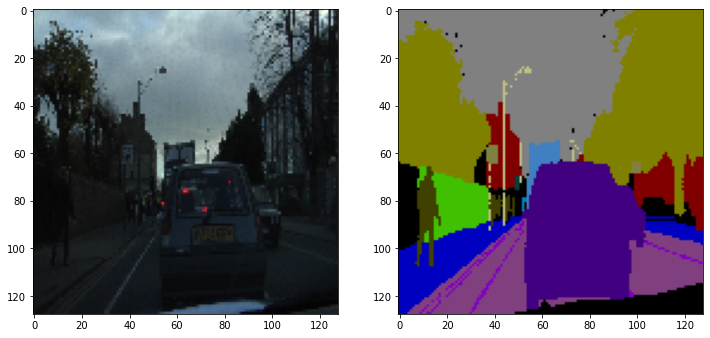

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(dataset.train_images[0].convert('RGBA'))
ax[1].imshow(dataset.train_masks[0].convert('RGBA'))

In [13]:
(X_train, X_test, X_val) = dataset.split_images()

(369, 128, 128, 3)
(232, 128, 128, 3)
(100, 128, 128, 3)


In [14]:
[y_train, y_test, y_val] = dataset.split_masks()

(369, 128, 128, 32)
(232, 128, 128, 32)
(100, 128, 128, 32)


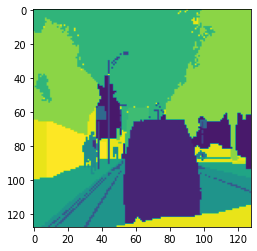

In [15]:
cat_yi, ind_yi = dataset.color2index(image.img_to_array(dataset.train_masks[3]))
plt.imshow(ind_yi)
plt.show()  

In [16]:
ind_yi

array([[22., 22., 22., ..., 27., 27., 27.],
       [22., 22., 22., ..., 27., 27., 27.],
       [22., 22., 22., ..., 27., 27., 27.],
       ...,
       [20., 20., 20., ..., 31., 31., 31.],
       [20., 20., 20., ..., 31., 31., 31.],
       [20., 20., 20., ..., 31., 31., 31.]])

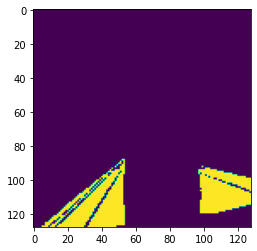

In [17]:
plt.imshow(cat_yi[..., 17])
plt.show()

In [18]:
cat_yi.shape

(128, 128, 32)

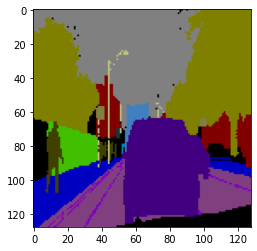

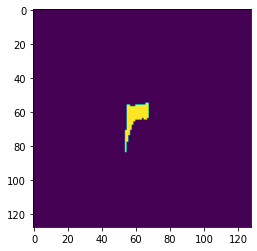

In [19]:
n = 0
plt.imshow(dataset.train_masks[n].convert('RGBA'))
plt.show()
img = y_train[n][..., 22]

plt.imshow(img)
plt.show()

Training:

In [20]:
src = list(files.upload().values())[0]
open('UNet_impl2.py','wb').write(src)

Saving UNet_impl2.py to UNet_impl2.py


1554

In [21]:
import UNet_impl2 as unet

In [22]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [23]:
model = unet.build_unet(32, (128, 128, 3))
model.compile(
  optimizer='adam',
  loss=bce_dice_loss,
  metrics=[iou, dice_coef, tf.keras.metrics.MeanIoU(num_classes=32), 'accuracy'])

In [24]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [25]:
def map_class_to_rgb(p):
    return idx2rgb[p[0]]

def show_prediction(model, ind, dataset_images, dataset_masks, images):
    img = images[ind]
    img = np.expand_dims(img,axis=0) # (128, 128, 3)
    pred_mask = model.predict(img) # (1, 128, 128, 3)
    pred_mask = np.argmax(pred_mask, axis=-1) # (1, 128, 128)
    rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))
    rgb_mask = rgb_mask.reshape((128, 128, 3))
    fig, ax = plt.subplots(1, 3, figsize=(12, 12))
    ax[0].imshow(dataset_images[ind].convert('RGBA'))
    ax[1].imshow(dataset_masks[ind])
    ax[2].imshow(rgb_mask)
    plt.show()
    
class DisplayCallback(Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_prediction(self.model, 0, dataset.train_images, dataset.train_masks, X_train)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

In [26]:
X_train.shape

(369, 128, 128, 3)

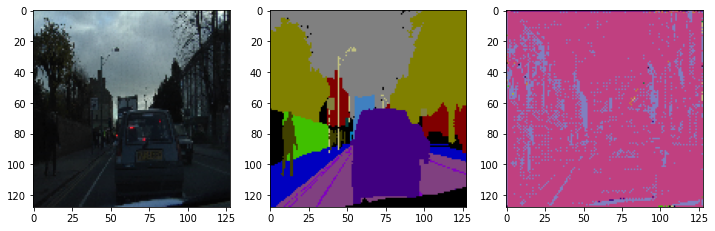

In [27]:
show_prediction(model, 0, dataset.train_images, dataset.train_masks, X_train)

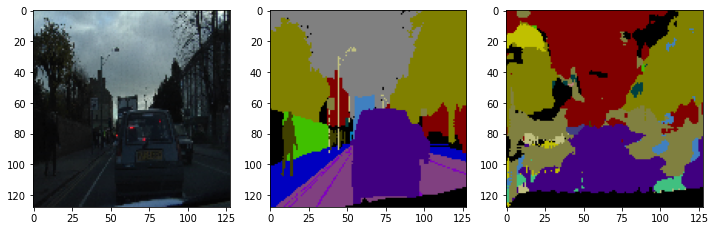


Sample Prediction after epoch 100
37/37 [==============================] - 9s 240ms/step - loss: 0.0623 - iou: 0.9025 - dice_coef: 0.9487 - mean_io_u: 0.4890 - accuracy: 0.9515 - val_loss: 0.1365 - val_iou: 0.8036 - val_dice_coef: 0.8900 - val_mean_io_u: 0.4877 - val_accuracy: 0.8926


In [28]:
model.fit(preprocess_input(X_train), y_train,
        epochs=100,
        batch_size=10,
        validation_data=(preprocess_input(X_val), y_val),
        callbacks=[DisplayCallback()])

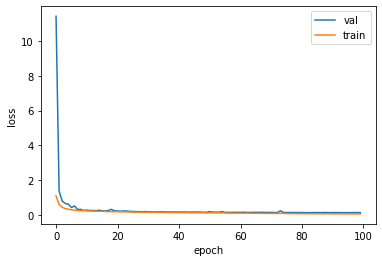

In [29]:
plt.plot(model.history.history['val_loss'], label='val')
plt.plot(model.history.history['loss'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

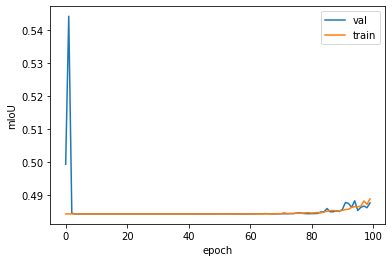

In [35]:
plt.plot(model.history.history['val_mean_io_u'], label='val')
plt.plot(model.history.history['mean_io_u'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mIoU')
plt.show()

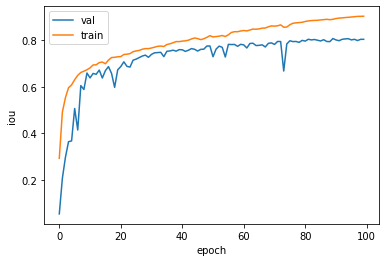

In [31]:
plt.plot(model.history.history['val_iou'], label='val')
plt.plot(model.history.history['iou'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('iou')
plt.show()

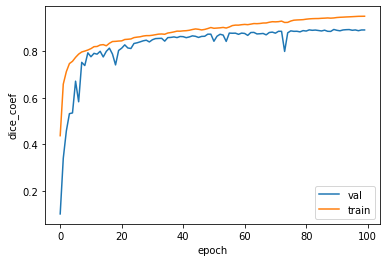

In [36]:
plt.plot(model.history.history['val_dice_coef'], label='val')
plt.plot(model.history.history['dice_coef'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

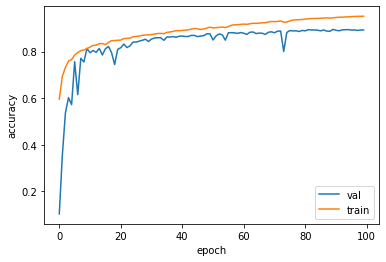

In [33]:
plt.plot(model.history.history['val_accuracy'], label='val')
plt.plot(model.history.history['accuracy'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Save the model:

In [34]:
model.save_weights('saved_model/model4')